In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [2]:
%matplotlib inline

In [3]:
! ls zippedData

bom.movie_gross.csv.gz
im.db
im.db.zip
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


### Saving each non-SQL file as a DataFrame

In [4]:
gross_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [5]:
info_rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')

In [6]:
reviews_rt = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')

In [7]:
movies_tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [8]:
budgets_tn = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### Exloring the SQL database for IMDb

In [9]:
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip, path='ZippedData')

In [10]:
# Created a new file called im.db
# CAREFUL because this file is too big to push to GitHub...

In [11]:
con = sqlite3.connect('zippedData/im.db')

In [12]:
pd.read_sql("""
SELECT *
FROM sqlite_schema
WHERE type='table'
""", con)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


## Question 1:
**What are the top 10 genres Microsoft should focus on?**

### Merging the IMDb `movie_basics` and `movie_ratings` files

In [13]:
imdb_movies_plus_ratings = pd.read_sql("""
SELECT * FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
""" , con)

In [14]:
# Preivew the resulting DataFrame
imdb_movies_plus_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [15]:
imdb_movies_plus_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


In [16]:
imdb_movies_plus_ratings.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
averagerating      72288
numvotes           72288
dtype: int64

In [17]:
imdb_movies_plus_ratings.isna().sum()/len(imdb_movies_plus_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000144
start_year         0.000000
runtime_minutes    0.217176
genres             0.037005
averagerating      0.494635
numvotes           0.494635
dtype: float64

### There are several columns with null data to contend with.
Let's start with the `averagerating` and `numvotes` columns.

In [18]:
imdb_movies_plus_ratings.isna()['averagerating'].equals(imdb_movies_plus_ratings.isna()['numvotes'])

True

**These two columns are are null in all the same rows.**

### Below, we view a sample of the titles where there are no ratings or votes.

They appear to be mostly niche titles, many with missing runtimes under one hour or runtimes under one hour. They are not representative of the content Microsoft wants to promote as it debuts its streaming service.

Although they make up about half the dataset, we are not likely to derive any meaningful insight from these titles. Keeping them would disrupt our analysis and there's no value we can replace them with. For these reasons we'll drop these rows. Fortunately, our dataset will still have about 70,000 entries to work with.

In [19]:
NaN_imdb_movies_plus_ratings = imdb_movies_plus_ratings[
    imdb_movies_plus_ratings['numvotes'].isna()]

In [20]:
NaN_imdb_movies_plus_ratings.sample(20)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
34570,tt2279297,Sudanna al Habib,Sudanna al Habib,2012,92.0,Documentary,NaN,NaN
65890,tt3757724,La ley de la quinta,La ley de la quinta,2016,NaN,Comedy,NaN,NaN
135818,tt8630006,Lost Time Matador,Lost Time Matador,2018,51.0,"Action,Biography,History",NaN,NaN
126736,tt7748186,Way of Angklung,Way of Angklung,2017,16.0,Documentary,NaN,NaN
39043,tt2396557,Lemon Drop,Lemon Drop,2018,NaN,"Drama,Romance",NaN,NaN
81234,tt4669454,The Silenced Walls,The Silenced Walls,2015,88.0,"Documentary,Drama",NaN,NaN
127795,tt7839454,Project 74,Project 74,2018,NaN,Crime,NaN,NaN
49118,tt2923876,Children of the Diaspora: For Peace and Democracy,Children of the Diaspora: For Peace and Democracy,2013,56.0,"Documentary,Family,History",NaN,NaN
123215,tt7471974,Managed Retreat,Managed Retreat,2018,18.0,Documentary,NaN,NaN
2525,tt10260672,Chonda Pierce: Unashamed,Chonda Pierce: Unashamed,2019,90.0,Documentary,NaN,NaN


In [21]:
# Dropping titles with no votes or rating

imdb_movies_plus_ratings.dropna(subset=['numvotes'], inplace=True)

In [22]:
# confirming that this worked for both the numvotes and averagerating columns:

print(imdb_movies_plus_ratings['averagerating'].isnull().sum())
print(imdb_movies_plus_ratings['numvotes'].isnull().sum())

0
0


In [23]:
# Reminding myself of the basic info in the dataset 
imdb_movies_plus_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 146134
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.1+ MB


In [24]:
imdb_movies_plus_ratings.isna().sum()/len(imdb_movies_plus_ratings)

movie_id           0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
runtime_minutes    0.103174
genres             0.010886
averagerating      0.000000
numvotes           0.000000
dtype: float64

**In the remaining dataset, about 1 percent of the titles are missing genres. Since genres are going to be central to our recommendations, we'll drop those rows, too.**

In [25]:
imdb_movies_plus_ratings.dropna(subset=['genres'], inplace=True)

### Checking if there are any duplicate titles.

In [26]:
imdb_movies_plus_ratings.duplicated(subset='original_title').sum()

2707

**There are bound to be tons of movies with the same name out there.**

**Let's see if there are movies with the same name, runtime, and year.**

In [27]:
imdb_movies_plus_ratings[
    imdb_movies_plus_ratings.duplicated(
        subset=[
            'original_title', 'runtime_minutes', 'start_year'])]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
2658,tt10275936,Raggarjävlar (Swedish Greasers),Raggarjävlar (Swedish Greasers),2019,70.0,Documentary,6.9,47.0
11830,tt1644694,The Gift,The Gift,2010,NaN,"Animation,Drama",5.9,7.0
12984,tt1674217,Transit,Transit,2010,80.0,"Biography,Documentary,Family",6.7,13.0
19111,tt1825978,The Artist,The Artist,2011,100.0,Thriller,6.8,6.0
23887,tt1967651,Unconditional Love,Unconditional,2012,92.0,"Drama,Thriller",5.6,660.0
24139,tt1977822,Inside,Inside,2012,85.0,Horror,4.0,397.0
33380,tt2246595,Blood Money,Blood Money,2012,109.0,"Action,Drama,Thriller",5.2,881.0
37698,tt2363471,The Summit,The Summit,2012,95.0,"Adventure,Documentary",6.9,4147.0
47280,tt2805202,Rise of the Undead,Rise of the Undead,2013,70.0,Action,4.2,20.0
50941,tt3019098,The Last Act,The Last Act,2012,NaN,Thriller,5.7,6.0


**We should delete the duplicates, but we should keep the version with the higher vote count.**

In [28]:
imdb_movies_plus_ratings.sort_values(by='numvotes', ascending=False, inplace=True)

In [29]:
imdb_movies_plus_ratings.drop_duplicates(subset=[
            'original_title', 'runtime_minutes', 'start_year'], inplace=True, keep='first')

In [30]:
imdb_movies_plus_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"Action,Thriller",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334.0
20342,tt1853728,Django Unchained,Django Unchained,2012,165.0,"Drama,Western",8.4,1211405.0
356,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655.0


**The values in the genres column contain multiple genres separated by a comma. I'll need to split them up them somehow.**

In [31]:
# pd.explode()

In [32]:
clean_genres = imdb_movies_plus_ratings.copy()

In [33]:
clean_genres['genres'] = clean_genres['genres'].str.split(',')

In [34]:
clean_genres.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,"[Action, Adventure, Sci-Fi]",8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,"[Action, Thriller]",8.4,1387769.0
311,tt0816692,Interstellar,Interstellar,2014,169.0,"[Adventure, Drama, Sci-Fi]",8.6,1299334.0


In [35]:
# Creating a list of all unique genres.
genres_all = set()
genres_col = clean_genres['genres']

for glist in genres_col:
    for g in glist:
        genres_all.add(g)

In [36]:
print(f'There are {len(genres_all)} genres on IMDb. They are:\n\n {genres_all}.')

There are 26 genres on IMDb. They are:

 {'Music', 'Fantasy', 'Animation', 'Drama', 'Horror', 'Musical', 'News', 'Game-Show', 'Sci-Fi', 'Adventure', 'Family', 'Western', 'History', 'Documentary', 'Short', 'Adult', 'Comedy', 'Romance', 'Action', 'Reality-TV', 'Sport', 'Mystery', 'Crime', 'War', 'Biography', 'Thriller'}.


**Creating a new dataset where the genres are separated**

In [37]:
expl_clean_genres = clean_genres.explode('genres')

In [38]:
expl_clean_genres.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
7066,tt1375666,Inception,Inception,2010,148.0,Action,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Adventure,8.8,1841066.0
7066,tt1375666,Inception,Inception,2010,148.0,Sci-Fi,8.8,1841066.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Action,8.4,1387769.0
6900,tt1345836,The Dark Knight Rises,The Dark Knight Rises,2012,164.0,Thriller,8.4,1387769.0


In [39]:
expl_clean_genres['genres'].value_counts()

Drama          30784
Documentary    17748
Comedy         17289
Thriller        8212
Horror          7672
Action          6986
Romance         6586
Crime           4610
Adventure       3817
Biography       3807
Family          3411
Mystery         3038
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1967
Animation       1742
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genres, dtype: int64

**Removing titles in genres that seem to be causing noise**

In [40]:
titles_in_noisy_genres = (
    expl_clean_genres[
        expl_clean_genres['genres'].isin(
            ['Game-Show', 'Short', 'Adult','Reality-TV'])]['movie_id'])

In [41]:
# model
# clean_genres.drop(index=clean_genres[clean_genres['movie_id'].isin(titles_in_noisy_genres)]['movie_id'].index)

In [42]:
for dataset in [clean_genres, expl_clean_genres, imdb_movies_plus_ratings]:
    dataset.drop(index=dataset[dataset['movie_id'].isin(titles_in_noisy_genres)]['movie_id'].index, inplace=True)

In [43]:
expl_clean_genres['genres'].value_counts()

Drama          30779
Documentary    17738
Comedy         17285
Thriller        8211
Horror          7671
Action          6984
Romance         6586
Crime           4610
Adventure       3815
Biography       3806
Family          3411
Mystery         3038
History         2824
Sci-Fi          2206
Fantasy         2126
Music           1966
Animation       1742
Sport           1179
War              853
Musical          721
News             578
Western          280
Name: genres, dtype: int64

### Measuring Success

I plan to use rating and number of votes as indicators of success. In the streaming age, these metrics are are arguably better indicators of a movie's popularity (and therefore incentive to subscribe to streaming service) as opposed to box office revenue and ROI.

Below, I start to explore the distributrions of `averagerating` and `numvotes`.

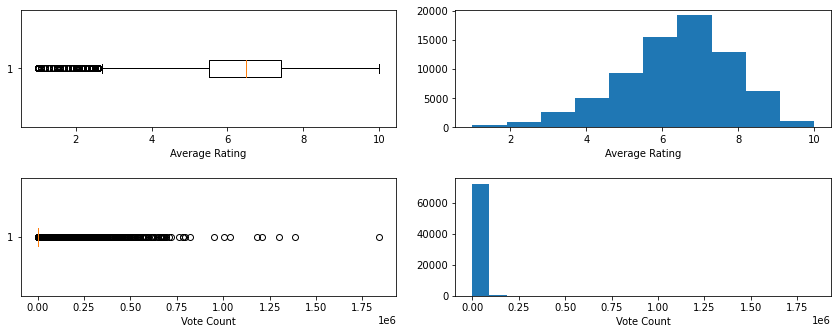

In [44]:
fig, ((ax_rating_box, ax_rating_hist), (ax_votes_box, ax_votes_hist)) = plt.subplots(
    nrows=2, ncols=2, figsize=(12,5))

ax_rating_box.boxplot(imdb_movies_plus_ratings['averagerating'], vert=False)
ax_rating_hist.hist(imdb_movies_plus_ratings['averagerating'])
ax_rating_box.set_xlabel('Average Rating')
ax_rating_hist.set_xlabel('Average Rating')

ax_votes_box.boxplot(imdb_movies_plus_ratings['numvotes'], vert=False)
ax_votes_hist.hist(imdb_movies_plus_ratings['numvotes'], bins=20)
ax_votes_box.set_xlabel('Vote Count')
ax_votes_hist.set_xlabel('Vote Count')

plt.tight_layout(pad=2);

**Something is clearly off about the distribution of vote counts.**

There's a disproportionate number of titles with low vote counts.

Taking a look at these titles.

In [45]:
mean_votes = imdb_movies_plus_ratings['numvotes'].mean()
mean_votes

3564.0968895098

In [46]:
median_votes = imdb_movies_plus_ratings['numvotes'].median()
median_votes

51.0

In [47]:
q90_votes = imdb_movies_plus_ratings['numvotes'].quantile(.90)
q90_votes

1621.0

In [48]:
imdb_movies_plus_ratings.query(f"numvotes < {q90_votes}")

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
21754,tt1891892,Quiz,Quiz,2012,85.0,"Crime,Drama,Thriller",6.0,1620.0
132542,tt8290698,The Spy Gone North,Gongjak,2018,137.0,Drama,7.2,1620.0
22442,tt1922679,Open Road,Open Road,2013,85.0,"Action,Drama,Thriller",5.5,1619.0
16785,tt1772261,The Curse of Downers Grove,The Curse of Downers Grove,2015,89.0,"Drama,Horror,Mystery",4.5,1618.0
74196,tt4229298,The Unspoken,The Unspoken,2015,91.0,"Horror,Thriller",4.9,1618.0
...,...,...,...,...,...,...,...,...
58705,tt3417906,The Nose,The Nose,2013,52.0,Documentary,8.6,5.0
93803,tt5465608,Extramaterial,Extramaterial,2016,59.0,Documentary,6.6,5.0
81438,tt4681636,Free Spaces,Free Spaces,2015,60.0,Documentary,9.0,5.0
48978,tt2915328,Abou Al Oureef,Abou Al Oureef,2014,96.0,Comedy,5.2,5.0


**This is *most* of our current dataset. But again, we don't want niche, lesser-known titles to pollute our conclusions. A client like Microsoft will want to model its movie business on titles that have broad appeal or are at least well-known.**

Below, we drop all movies from our current datasets except those whose number of votes is in top 10 percent.

In [49]:
for dataset in [clean_genres, expl_clean_genres, imdb_movies_plus_ratings]:
    dataset.drop(index=dataset.query(f"numvotes < {q90_votes}").index, inplace=True)

In [50]:
imdb_movies_plus_ratings.shape

(7304, 8)

**As a result we are left with a dataset with more than 7,000 movies. Let's look at those distributions again.**

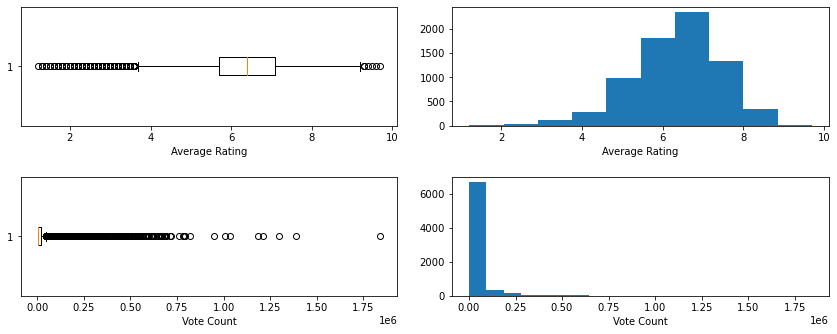

In [51]:
# copied from above

fig, ((ax_rating_box, ax_rating_hist), (ax_votes_box, ax_votes_hist)) = plt.subplots(
    nrows=2, ncols=2, figsize=(12,5))

ax_rating_box.boxplot(imdb_movies_plus_ratings['averagerating'], vert=False)
ax_rating_hist.hist(imdb_movies_plus_ratings['averagerating'])
ax_rating_box.set_xlabel('Average Rating')
ax_rating_hist.set_xlabel('Average Rating')

ax_votes_box.boxplot(imdb_movies_plus_ratings['numvotes'], vert=False)
ax_votes_hist.hist(imdb_movies_plus_ratings['numvotes'], bins=20)
ax_votes_box.set_xlabel('Vote Count')
ax_votes_hist.set_xlabel('Vote Count')

plt.tight_layout(pad=2);

**This *slightly* improved the workability of these distributions, but they're still skewed, even after we dumped most of the dataset.**

The reality is that in the film industry, a ton of content is made, and only a select few enter the cultural zeitgeist. This will have to do. We'll use median to measure the average rating and number of votes.

Now, let's see what kind of relationship there is between number of votes and rating.

In [52]:
print('Correlation between number of votes and average rating: {}'.format(
    np.corrcoef(
        imdb_movies_plus_ratings['numvotes'], imdb_movies_plus_ratings['averagerating'])[0,1]))

Correlation between number of votes and average rating: 0.2126063733913749


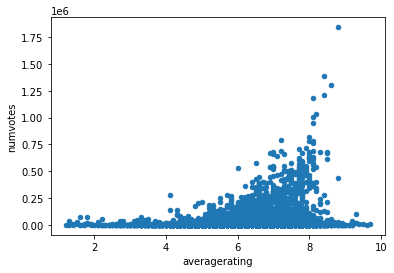

In [53]:
imdb_movies_plus_ratings.plot(kind='scatter', x='averagerating', y='numvotes');
# sns.scatterplot(x=imdb_movies_plus_ratings['averagerating'], y=imdb_movies_plus_ratings['numvotes'])

**There's a positive relationship between average rating and number of votes.**

I am making the assumption that a higher number of votes means that more people have seen the movie, regardless of whether they voted for a rating of 1 or 10. I am also assuming that that Microsoft wants to make movies that are **more likely to be seen**, regardless of whether or not they're critically acclaimed. **Therefore, our measure of success will be number of votes.**

In choosing this as our measure of success, we are reassured that that metric is associated with a higher rating anyway.

### Below, we group movies by genre and see the means of `averagerating` and `numvotes` for each genre.

In [54]:
# Pivot table showing the means of averagerating and numvotes.
pivot_genres = pd.pivot_table(
    data=expl_clean_genres,
    values=['averagerating', 'numvotes'],
    index='genres',
    aggfunc=np.median
).sort_values(by='numvotes', ascending=False).reset_index()
pivot_genres

,genres,averagerating,numvotes
0,Adventure,6.4,16484.0
1,Fantasy,6.1,10546.0
2,Sci-Fi,5.9,10067.0
3,Animation,6.8,9354.0
4,Mystery,6.2,8494.0
5,Western,6.3,8284.5
6,Action,6.2,7543.5
7,Crime,6.4,7414.0
8,Biography,7.0,6560.0
9,Romance,6.4,6540.5


Now that we finally have aggregate measures based on genres, we can analyze which genres are most successful.

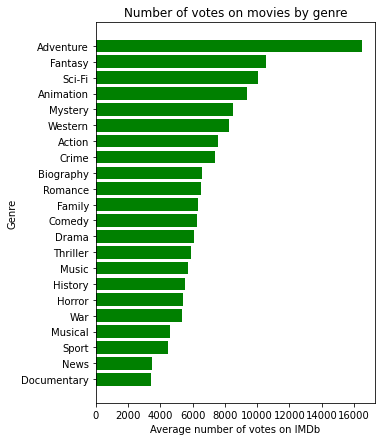

In [55]:
fig, ax = plt.subplots(figsize=(5, 7))

ax.barh(y=pivot_genres['genres'][::-1], width=pivot_genres['numvotes'][::-1], color='green')
ax.set_xlabel('Average number of votes on IMDb')
ax.set_ylabel('Genre')
ax.set_title('Number of votes on movies by genre');

# sns.barplot(x=pivot_genres['numvotes'], y=pivot_genres['genres'], orient='h')

In [56]:
print('The top 10 genres in terms of IMDb average rating are:')
print()
for g in pivot_genres.iloc[:10]['genres']:
    print(g)

The top 10 genres in terms of IMDb average rating are:

Adventure
Fantasy
Sci-Fi
Animation
Mystery
Western
Action
Crime
Biography
Romance


**The genres listed above are the best performing IMDb.**

That doesn't mean these genres perform well on their own. It's important to note that we split up the genres before we did this analysis. That means a sci-fi movie that is also a comedy movie might also perform well.

## Conclusion 1:
**Microsoft should focus on movies that include combinations of the following genres:**
- Adventure
- Fantasy
- Sci-Fi
- Animation
- Mystery
- Western
- Action
- Crime
- Biography
- Romance


---
---
---

## Question 2

**Comedy fans might be dismayed by these the first recommendation. It's a major genre that got wiped out due to the statistical analysis.**

**What can we learn from comedies that are among the most successful movies?**

**Among the top 25 percent of movies (in terms of number of votes), what proportion are comedies?**

In [57]:
clean_genres['is_comedy'] = ['Comedy' in row for row in clean_genres['genres']]

In [58]:
clean_genres.sample(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,is_comedy
9900,tt1581835,Daydream Nation,Daydream Nation,2010,98.0,"[Drama, Romance]",6.4,11759.0,False
42709,tt2554270,The Tower,Ta-weo,2012,121.0,"[Action, Drama]",6.6,4485.0,False
51354,tt3043252,Parched,Parched,2015,116.0,[Drama],7.6,4124.0,False
102233,tt5980638,The Transcendents,The Transcendents,2018,96.0,"[Music, Mystery, Thriller]",6.8,1716.0,False
90262,tt5222768,White Fang,Croc-Blanc,2018,85.0,"[Adventure, Animation]",7.0,2048.0,False


In [59]:
comedies = clean_genres.query("is_comedy == True")
non_comedies = clean_genres.query("is_comedy == False")

In [60]:
comedies.shape

(2281, 9)

In [61]:
non_comedies.shape

(5023, 9)

In [62]:
q75_clean_genres = clean_genres['numvotes'].quantile(.75)
q75_clean_genres

19707.5

In [63]:
top25_clean_genres = clean_genres.query(f"numvotes >= {q75_clean_genres}")
top25_clean_genres.sample(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,is_comedy
20703,tt1862079,Safety Not Guaranteed,Safety Not Guaranteed,2012,86.0,"[Comedy, Drama, Romance]",7.0,111907.0,True
88191,tt5117670,Peter Rabbit,Peter Rabbit,2018,95.0,"[Adventure, Animation, Comedy]",6.6,27908.0,True
5867,tt1204342,The Muppets,The Muppets,2011,103.0,"[Adventure, Comedy, Family]",7.1,82752.0,True
36649,tt2334873,Blue Jasmine,Blue Jasmine,2013,98.0,[Drama],7.3,179453.0,False
42886,tt2561572,Get Hard,Get Hard,2015,100.0,"[Comedy, Crime]",6.0,111187.0,True


In [64]:
comedy_breakdown = top25_clean_genres['is_comedy'].value_counts()
comedy_breakdown

False    1210
True      616
Name: is_comedy, dtype: int64

In [65]:
comedy_breakdown_norm = top25_clean_genres['is_comedy'].value_counts(normalize=True)
comedy_breakdown_norm

False    0.662651
True     0.337349
Name: is_comedy, dtype: float64

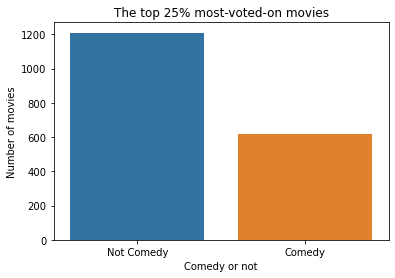

In [66]:
sns.barplot(x=comedy_breakdown.index,
            y=comedy_breakdown.values
           ).set(xlabel='Comedy or not',
                 ylabel='Number of movies',
                 xticklabels=['Not Comedy', 'Comedy'],
                 title='The top 25% most-voted-on movies');

**Of the top 25% best-performing movies, 33.73% are comedies.**

## Conclusion 2:
**Microsoft should focus about a third of its efforts (in terms of budget or number of movies) on making comedic movies.**

---
---
---

## Question 3:

**Along the same lines as Question 2:**

**Among the top 25 percent of movies (in terms of number of votes), what proportion are animated?**

In [67]:
clean_genres['is_animated'] = ['Animation' in row for row in clean_genres['genres']]

In [68]:
q75_clean_genres = clean_genres['numvotes'].quantile(.75)

In [69]:
top25_clean_genres = clean_genres.query(f"numvotes >= {q75_clean_genres}")

In [70]:
animated = clean_genres.query("is_animated == True")
not_animated = clean_genres.query("is_animated == False")

In [71]:
animated.shape

(287, 10)

In [72]:
not_animated.shape

(7017, 10)

In [73]:
animated_breakdown = top25_clean_genres['is_animated'].value_counts()
animated_breakdown

False    1718
True      108
Name: is_animated, dtype: int64

In [74]:
animated_breakdown_norm = top25_clean_genres['is_animated'].value_counts(normalize=True)
animated_breakdown_norm

False    0.940854
True     0.059146
Name: is_animated, dtype: float64

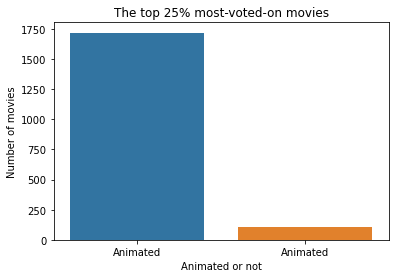

In [75]:
sns.barplot(x=animated_breakdown.index,
            y=animated_breakdown.values
           ).set(xlabel='Animated or not',
                 ylabel='Number of movies',
                 xticklabels=['Animated', 'Animated'],
                 title='The top 25% most-voted-on movies');

**Of the top 25% best-performing movies, 5.91% are animated.**

## Conclusion 3:

**Microsoft should focus about a 6 percent of its efforts (in terms of budget or number of movies) on making animated movies.**